In [1]:
import pandas as pd
import numpy as np
import time, os, sys, gc, json

from scipy import stats
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
plt.style.use('dark_background')

In [2]:
DATA_IMG_SIZE = 512 # size of images on disk
dataset_loc = "C:\\Users\\Alex\\Desktop\\VRPose Research Project\\PeopleSansPeople\\images\\"

datasets = os.listdir(dataset_loc)
print(datasets)

['f40493d3-d7eb-47c0-8606-3c723ee826ba']


In [3]:
selected_dataset = datasets[0] 

In [4]:
def process_dataset(loc, return_semantic=False):
    data = os.listdir(loc)
    capdata_loc = loc + [x for x in data if "Dataset" in x][0]
    captures = [capdata_loc+'\\'+x for x in os.listdir(capdata_loc) if "captures" in x]
    rgb_loc = loc + [x for x in data if "RGB" in x][0]
    rgbs = [rgb_loc+'\\'+x for x in os.listdir(rgb_loc)]
    if return_semantic:
        semseg_loc = [x for x in data if "Semantic" in x][0]
        semseg = [semseg_loc+'\\'+x for x in os.listdir(loc + semseg_loc)]
        return captures, rgbs, semseg
    return captures, rgbs

def handle_captures(captures):
    dfs = []
    for capture in captures:
        df = pd.json_normalize(pd.read_json(capture).values[:,1])[['id','sequence_id','step',
                                                        'timestamp','filename','annotations']]
#         print(df.columns)
        df.columns = ['row_id', 'seq_id','step','timestamp','rgb_filename','annotations']
        df['keypoints'] = [x[2]['values'][0]['keypoints'] if x[2]['values'] else None for 
                           x in df['annotations'].values]
        df['seg_filename'] = [x[1]['filename'] for x in df['annotations'].values]
        df['seg_filename'] = dataset_loc + selected_dataset + "\\" + df['seg_filename']
        df['rgb_filename'] = dataset_loc + selected_dataset + "\\" + df['rgb_filename']
        df = df.drop('annotations',axis=1)
        dfs.append(df)
    return pd.concat(dfs)            

def decomp_keypoints(dfs, img_size=512, return_semantic=False): 
    cdfv = dfs[['keypoints', 'rgb_filename', 'seg_filename']].values
    Y = []
    X = []
    Z = []
    c = 0
    for vals in cdfv: # might be worth trying to multithread this
        if vals[0] is not None:
            df = pd.json_normalize(vals[0])
            dxyval = df[['x','y']].values
            if (df['state'].values.sum() > 11 # makes sure most keypoints are visible
                and np.all(dxyval>6)          # checks whether keypoints are off the img edge
                and np.all(dxyval<(img_size-6))):
                dvxyz = df[['vx','vy','vz']].values
                fdist = np.sqrt((dvxyz[0] - dvxyz[-1]) ** 2).sum()
                
                y = np.concatenate((
                    (df[['x','y']].values / img_size)[:15],
                    (df['state'].values / 2)[:15].reshape(-1,1),
                    ((dvxyz - dvxyz[0]) / fdist)[:15]
                    ), axis=-1)
                
                x = vals[1]
                z = vals[2]
                X.append(x); Y.append(y); Z.append(z)
        c+=1
        if c%1000==0: percFin(c, len(cdfv))
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    return X, Z, Y

def filter_images(imgs): # could take several minutes for ~100000 images, 
    output = []          # theres probably a more efficient way to code this / multiprocessing
    for filename in imgs:
        fg = True
        img = imread(filename) * 255
#         print(img)
        if img.std() < 11: # checks for images with low variance and low or high values
            m = img.mean() # indicating either an entirely dark or whashed out image
            if m < 11 or m > 220:
                fg = False
        output.append(fg)
    return np.array(output)

In [5]:
# checks if data preprocessing and image filtering has already been saved
if os.path.isfile(dataset_loc + selected_dataset + "\\" + 'keypoints.npy'):
    keypoints = np.load(dataset_loc + selected_dataset + "\\" + 'keypoints.npy')
    rgbs = np.load(dataset_loc + selected_dataset + "\\" + 'rgbs.npy')
    segs = np.load(dataset_loc + selected_dataset + "\\" + 'segs.npy')
    print(keypoints.shape, rgbs.shape, segs.shape)
else:
    FX = process_dataset(dataset_loc + selected_dataset + '\\', return_semantic=True)

    dfs = handle_captures(FX[0])

    rgbs, segs, keypoints = decomp_keypoints(dfs, img_size=DATA_IMG_SIZE, return_semantic=True)

    good_imgs = filter_images(rgbs)
    # may take some time to process

    rgbs = rgbs[good_imgs]
    segs = segs[good_imgs]
    keypoints = keypoints[good_imgs]

    np.save(dataset_loc + selected_dataset + "\\" + 'keypoints.npy', keypoints)
    np.save(dataset_loc + selected_dataset + "\\" + 'rgbs.npy', rgbs)
    np.save(dataset_loc + selected_dataset + "\\" + 'segs.npy', segs)
    print(keypoints.shape, rgbs.shape, segs.shape)

(435, 15, 6) (435,) (435,)


In [6]:
from sklearn import decomposition, ensemble, metrics, pipeline
from sklearn.decomposition import PCA
# from xgboost import XGBRegressor

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

import tensorflow.keras.layers as layers
import tensorflow.keras.backend as backend
import tensorflow.keras.models as models

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import regularizers, Model

import tensorflow_addons as tfa
import tensorflow_probability as tfp

gc.collect()
tf.keras.backend.clear_session()

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [7]:
IMG_SIZE = 512 # image size in model (may need to be scaled down)
BATCH_SIZE = 256

def decode_image(filename, label=None):
    bits = tf.io.read_file(filename)
    img = tf.io.decode_png(bits, channels=3)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
#     img = tf.image.per_image_standardization(img)  # may be necessary depending on model
    return img, label

def tdata(length=len(keypoints) - 10000, offset=0, labels=keypoints, bs=BATCH_SIZE):
    return (
        tf.data.Dataset
        .from_tensor_slices((rgbs[offset:offset+length], labels[offset:offset+length]))
        .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(bs)
#         .cache()
#         .shuffle(8)
        .prefetch(tf.data.AUTOTUNE)
    )

def vdata(length=10000, labels=keypoints, bs=BATCH_SIZE):
    return (
    tf.data.Dataset
    .from_tensor_slices((rgbs[-length:], labels[-length:]))
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE) 
    .batch(bs)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
# model training might look something like this

# model.fit(tdata(36000, labels=Labels ,bs=256, img_size=256), 
#           validation_data=vdata(3600, labels=Labels, bs=256, img_size=256),
#            epochs=100, verbose=1, callbacks=cbks)

In [8]:
VX = rgbs[len(keypoints)-1000:]
VY = keypoints[len(keypoints)-1000:].astype(np.float32)

# VP = model.predict(vdata(1000, bs=256, img_size=256)).astype(np.float32)
idx = 0

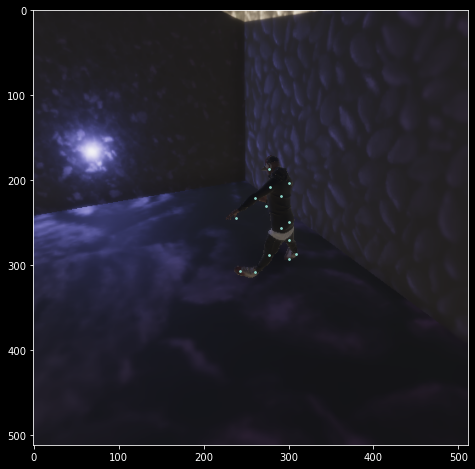

In [62]:
fig = plt.figure(figsize=(20,8))
# plt.subplot(1, 2, 1)
# plt.imshow(tf.io.decode_png(tf.io.read_file(VX[idx]), channels=3).numpy())
# plt.scatter(VP[idx][:,0]*IMG_SIZE, VP[idx][:,1]*IMG_SIZE, s=(np.arange(1)*5)+3)
# plt.subplot(1, 2, 2)
plt.imshow(tf.io.decode_png(tf.io.read_file(VX[idx]), channels=3).numpy())
plt.scatter(VY[idx][:,0]*IMG_SIZE, VY[idx][:,1]*IMG_SIZE, s=(np.arange(1)*5)+3)
plt.show()
idx += 5